In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow import keras
from scipy.stats import norm
from scipy.special import softmax
from sklearn.preprocessing import normalize

from vae import compute_mixture
from ans import code_rans, decode_rans
from bitsback import *

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

orig_x_train = x_train
orig_x_test = x_test

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


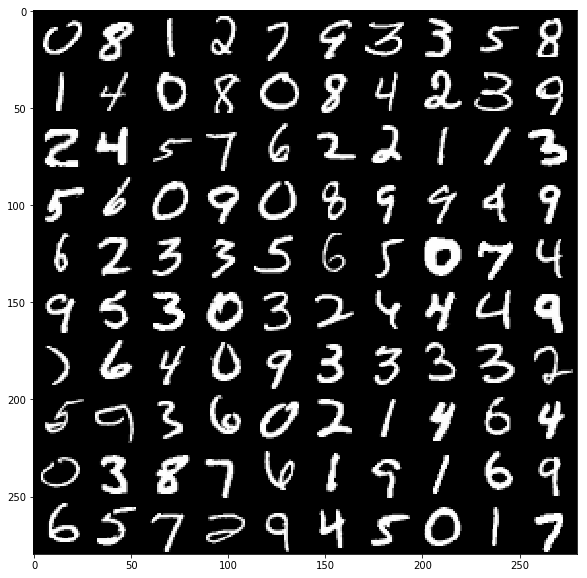

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

In [ ]:
def bitsback_append(data, stack, enc, dec, n_components=3, latent_size=50, quant_bits=16, stats=None):
    # Sample y from q(y|x_0) using the existing (ideally random) bits on the stack,
    # imaging that they were coded with a quantized q(y|x_0)
    # (This decreases coded message)
    q_dist = enc.predict((data.astype('float32') - 127.5) / 127.5)
    q_mu, q_log_var = q_dist[0], q_dist[1]
    prev_stack_size = len(stack)
    stack, indexes = decode_y(stack, q_mu[0], q_log_var[0], 
                              latent_size=latent_size, quant_bits=quant_bits)
    if stats is not None:
        if 'q' not in stats:
            stats['q'] = []
        stats['q'].append(8 * 4 * (len(stack) - prev_stack_size + 1))

    # Translate quantized index to real value using bins
    bins = norm_bins(quant_bits=quant_bits)
    y = bins[indexes]

    # Extract pixel distribution from decoder, flatten and quantize to frequencies
    dist = dec.predict(y.reshape(1, -1))    
    m = dist[0, :, :, :n_components]
    invs = dist[0, :, :, n_components:2*n_components]
    logit_weights = dist[0, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)

    pvals = compute_mixture(m, invs, weights, n_components)
    pvals = pvals.reshape(-1, pvals.shape[-1])
    freqs = quantize_pval_distribution(pvals, quant_bits=quant_bits)

    # Encode data using ANS (increase coded message size)
    data = data.reshape(-1)
    prev_stack_size = len(stack)
    stack = encode_x(data, freqs, stack)
    if stats is not None:
        if 'x' not in stats:
            stats['x'] = []
        stats['x'].append(8 * 4 * (len(stack) - prev_stack_size + 1))

    # Encode the sampled y values using isotropic normals
    prev_stack_size = len(stack)
    stack = encode_y(indexes, stack, quant_bits=quant_bits)
    if stats is not None:
        if 'y' not in stats:
            stats['y'] = []
        stats['y'].append(8 * 4 * (len(stack) - prev_stack_size + 1))

    return stack

stack = np.random.randint(low=0, high=(1 << 32) - 1, size=50, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
init_stack = stack.copy()
num_images = 100
stats = {}
for i in range(num_images):
    stack = bitsback_append(orig_x_test[i:(i+1)], stack, enc, dec, stats=stats)
    if (i > 0 and (i+1) % 10 == 0) or (i == num_images - 1):
        orig = 784 * (i + 1)
        compress = 4 * len(stack) + 4
        bits_per_dim = compress * 8 / orig
        print('[%s]: N=%05d, bits per dim=%.4f' % (datetime.now(), i+1, bits_per_dim))

[2021-01-24 17:33:37.937993]: N=00010, bits per dim=2.0082
[2021-01-24 17:33:41.859796]: N=00020, bits per dim=1.9490
[2021-01-24 17:33:45.812554]: N=00030, bits per dim=1.9102
[2021-01-24 17:33:49.681998]: N=00040, bits per dim=1.8653
[2021-01-24 17:33:53.543613]: N=00050, bits per dim=1.8163
[2021-01-24 17:33:57.496870]: N=00060, bits per dim=1.8238
[2021-01-24 17:34:01.483520]: N=00070, bits per dim=1.8350


In [ ]:
def bitsback_pop(stack, enc, dec, shape=(28, 28, 1), n_components=3, latent_size=50, quant_bits=16):
    # Decode y according to isotropic norms (decreases coded message size)
    stack, indexes = decode_y(stack, latent_size=latent_size, quant_bits=quant_bits)

    # Translate quantized index to real value using bins
    bins = norm_bins(quant_bits=quant_bits)
    y = bins[indexes]

    # Extract pixel distribution from decoder, flatten and quantize to frequencies
    dist = dec.predict(y.reshape(1, -1))
    m = dist[0, :, :, :n_components]
    invs = dist[0, :, :, n_components:2*n_components]
    logit_weights = dist[0, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)

    pvals = compute_mixture(m, invs, weights, n_components)
    pvals = pvals.reshape(-1, pvals.shape[-1])
    freqs = quantize_pval_distribution(pvals, quant_bits=quant_bits)

    # Decode data using ANS (decrease coded message size)
    stack, data = decode_x(freqs, stack)

    # Get y-distribution using encoder
    q_dist = enc.predict((data.reshape(-1, shape[0], shape[1], shape[2]) - 127.5) / 127.5)
    q_mu, q_log_var = q_dist[0], q_dist[1]

    # Encode data using ANS (increase coded message size)
    stack = encode_y(indexes, stack, q_mu[0], q_log_var[0], quant_bits=quant_bits)

    return data, stack

images = []
for i in range(num_images):
    data, stack = bitsback_pop(stack, enc, dec)
    images = [data] + images
print(len(stack))

In [ ]:
#images[0] == orig_x_test[0]
images[0].shape, orig_x_test[0].shape

In [ ]:
for i in range(num_images):
    x1 = np.array(images[i]).reshape(28, 28).tolist()
    x2 = orig_x_test[i].tolist()
    x1 == x2, stack == init_stack